#🧠 Desafio:
##Classificação de Imagens com CNN e Transfer Learning
Este notebook implementa e compara dois modelos de classificação de imagens usando o dataset Caltech-101 (com algumas classes removidas para balanceamento):

CNN do Zero: Rede convolucional desenvolvida manualmente.

VGG16 (Transfer Learning): Modelo pré-treinado no ImageNet com camadas finais adaptadas.

##Etapas do projeto:
📦 Carregamento e pré-processamento das imagens (224x224)

🔄 Normalização e codificação one-hot dos rótulos

🏗️ Construção dos modelos CNN e VGG16

🧪 Treinamento e validação

📊 Comparação de desempenho com gráficos de acurácia

📄 Geração de relatório técnico (.docx)

#### Importação de Bibliotecas e Configuração Inicial
1 - Garante que os gráficos gerados com matplotlib sejam exibidos diretamente no notebook.

3 - os: biblioteca padrão do Python para manipulação de arquivos, diretórios e variáveis de ambiente.

4 - random: usada para embaralhar dados (como conjuntos de imagens).

5 - numpy (np): biblioteca para operações numéricas e manipulação de arrays.

6 - keras: biblioteca de alto nível para construção e treinamento de redes neurais.

7 - matplotlib.pyplot (plt): usada para visualização de gráficos e imagens.

8 - keras.preprocessing.image: fornece utilitários para carregamento e pré-processamento de imagens.

9 - preprocess_input: função que aplica o mesmo pré-processamento usado em redes treinadas com ImageNet (como VGG16), ajustando os valores dos pixels.

10 - Sequential: modelo linear do Keras, onde as camadas são empilhadas sequencialmente.

11 - Camadas:

- Dense: camada totalmente conectada.

- Dropout: reduz overfitting, "desligando" aleatoriamente neurônios durante o treinamento.

- Flatten: transforma uma matriz em vetor (necessário antes da camada densa).

- Activation: aplica uma função de ativação (como ReLU, softmax).

- Conv2D: camada de convolução 2D (para extração de características visuais).

- MaxPooling2D: camada de subamostragem (reduz a dimensão espacial da imagem).

12 - Model: API funcional para definir modelos com estruturas mais complexas (ex: com múltiplas entradas/saídas ou transferência de aprendizado).

15 - Define explicitamente que o backend usado pelo Keras será o TensorFlow (a linha é útil apenas se houver alternância entre backends como Theano, o que hoje é raro).

In [1]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Model

# Se estiver usando Theano (opcional)
os.environ["KERAS_BACKEND"] = "tensorflow"


📦 Extração do Dataset Caltech-101

2 - !cp ...

Copia o arquivo compactado do dataset Caltech-101 do seu Google Drive para o diretório de trabalho atual no Colab.

- O caminho especificado ('/content/drive/My Drive/...) assume que o Google Drive já foi montado.

- O arquivo .tar.gz contém imagens organizadas por categorias (pastas).

3 - !tar -xvzf ...

Extrai o conteúdo do arquivo .tar.gz para uma nova pasta chamada 101_ObjectCategories.

- O tar é um utilitário de compactação/descompactação de arquivos no Linux.

- Parâmetros usados:

  -x: extrair

  -v: modo verboso (mostra o que está sendo extraído)

  -z: descomprime arquivos .gz

  -f: especifica o nome do arquivo a ser extraído

📁 Resultado

Após executar essas duas linhas:

- O diretório atual (raiz do ambiente de execução do Colab) terá uma nova pasta chamada 101_ObjectCategories/, com subpastas representando categorias de objetos como "camera", "cup", "elephant", etc.

- Esse diretório será utilizado para carregar e preparar os dados de imagens que alimentarão os modelos de redes neurais.

In [ ]:
# Extrair o dataset (já deve estar no seu Drive)
!cp '/content/drive/My Drive/BairesDev - Machine Learning Practitioner/caltech-101/101_ObjectCategories.tar.gz' .
!tar -xvzf 101_ObjectCategories.tar.gz

🗂️ Definição do Caminho e Parâmetros de Pré-processamento

2 - root = '101_ObjectCategories'

Define o diretório raiz onde estão localizadas as imagens do dataset Caltech-101, após a extração do arquivo .tar.gz.

Esse diretório contém subpastas, cada uma representando uma categoria de objeto (por exemplo: camera, cup, watch, etc.).

3 - exclude = [...]

Lista de categorias a serem excluídas da classificação.

- Estas categorias são frequentemente usadas em benchmarks específicos ou possuem muitas imagens, o que poderia gerar viés na distribuição das classes.

- Também são removidas classes com rostos (Faces, Faces_easy) e planos de fundo (BACKGROUND_Google) para focar em objetos mais diversos e equilibrar o conjunto de dados.

4 - train_split, val_split = 0.7, 0.15
Define a proporção de divisão dos dados:

- 70% das imagens serão usadas para o treinamento (train),

- 15% serão usadas para validação (val),

- E o restante (15%) será automaticamente destinado ao teste (test).

✅ Por que isso é importante?

Essa configuração ajuda a preparar corretamente os dados para o processo de treinamento do modelo, garantindo:

- Um conjunto diversificado e equilibrado.

- Uma separação clara entre treino, validação e teste.

- Que não haja contaminação dos dados de teste com categorias excluídas ou privilegiadas.


In [26]:
# Caminho e exclusões
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

🧠 Seleção de Categorias e Redução da Complexidade

2 - Percorre as pastas do diretório root (que contém as categorias do dataset Caltech-101).

- os.walk(root) percorre todas as subpastas do diretório.

- x[0] for x in os.walk(root) retorna apenas os caminhos das pastas (ignorando os arquivos).

- [1:] remove o próprio diretório root da lista (a primeira entrada).

3 - Exclui as categorias indesejadas, conforme definido anteriormente na lista exclude.

4 - Seleciona apenas um subconjunto das categorias disponíveis:

- categories[:5]: reduz para apenas 5 classes (ideal para treinos rápidos ou com pouca RAM).

- categories[:10]: reduz para 10 classes, oferecendo mais diversidade, mas exige mais memória, especialmente com imagens em resolução de 224x224 pixels (padrão do modelo VGG16).

5 - Imprime as categorias selecionadas, confirmando quais classes farão parte do modelo de classificação.

⚠️ Observação Importante:

Ao usar imagens com resolução maior (224x224), o uso de RAM aumenta consideravelmente. Portanto:

- Para ambientes com recursos limitados (ex: Google Colab gratuito), é recomendável trabalhar com menos categorias.

- Caso deseje expandir o número de classes, considere reduzir o tamanho das imagens (por ex. 64x64), mas isso pode exigir adaptar o modelo também.

In [27]:
# Selecionar categorias e reduzir para 5
categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
categories = categories[:5]  # ✅ Reduzir para 5 classes
print("Categorias:", categories)

Categorias: ['101_ObjectCategories/tick', '101_ObjectCategories/chair', '101_ObjectCategories/ant', '101_ObjectCategories/wild_cat', '101_ObjectCategories/ceiling_fan']


In [4]:
# Selecionar categorias e reduzir para 10 - aumenta muito a RAM com img (224X224)
categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
categories = categories[:10]  # ✅ Reduzir para 10 classes
print("Categorias:", categories)

Categorias: ['101_ObjectCategories/tick', '101_ObjectCategories/chair', '101_ObjectCategories/ant', '101_ObjectCategories/wild_cat', '101_ObjectCategories/ceiling_fan', '101_ObjectCategories/stop_sign', '101_ObjectCategories/octopus', '101_ObjectCategories/llama', '101_ObjectCategories/minaret', '101_ObjectCategories/gramophone']


🖼️ Carregamento e Pré-processamento das Imagens

1 - Função get_image(path): Carregamento e Pré-processamento das Imagens

Esta função carrega uma imagem a partir de um caminho específico (path) e a transforma em um formato compatível com modelos do Keras (CNNs, VGG16, etc). Os passos são:

2 - image.load_img(path, target_size=(...))

- Carrega a imagem e redimensiona para o tamanho desejado:

- 64x64: reduz consumo de memória (útil em ambientes com pouca RAM).

- 224x224: necessário para modelos como o VGG16, que requer esse formato de entrada.

3 - image.img_to_array(img)

- Converte a imagem PIL em um array NumPy (formato necessário para o modelo).

4 - np.expand_dims(x, axis=0)

- Adiciona uma nova dimensão para simular o lote (batch) de imagens, mesmo que com apenas 1 imagem:
De (64, 64, 3) → (1, 64, 64, 3).

5 - preprocess_input(x)

- Aplica o pré-processamento específico usado nos modelos do Keras (por exemplo, normalização baseada no ImageNet).

Fundamental quando se utiliza modelos pré-treinados, como o VGG16.

6 - Retorno:

- img: imagem original (PIL) – útil para visualização.

- x: imagem processada (NumPy) – usada para inferência ou treinamento.

⚠️ Quando usar cada uma?

✅ Versão 64x64: Útil quando seu objetivo é treinar um modelo próprio do zero (CNN simples) e precisa otimizar o uso de memória no Colab.

✅ Versão 224x224: Necessária para usar modelos pré-treinados como VGG16, ResNet, etc., pois esses modelos foram treinados com essa resolução.

In [5]:
def get_image(path): # Reduzir imagem para 64x64 - Pois 224 não rodou no colab, muito consumo de RAM
    img = image.load_img(path, target_size=(64, 64))  # ✅ tamanho reduzido 64X64
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [28]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))  # ✅ voltou para 224x224
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # obrigatório para modelos pré-treinados como VGG16
    return img, x

📥 Carregamento e Rotulagem das Imagens

Esse bloco de código percorre as categorias de imagens selecionadas (armazenadas em categories) e executa o carregamento, pré-processamento e rotulagem das imagens, salvando-as em uma lista chamada data.
2 - data = []

- Inicializa uma lista vazia que vai armazenar dicionários com a imagem (x) e sua classe (y).

3 - for c, category in enumerate(categories):

- Itera sobre as categorias (pastas com imagens), e atribui:

- c: índice numérico da categoria (será usado como rótulo).

- category: caminho da pasta da categoria (ex: '101_ObjectCategories/pizza').

4 - images = [...]

Usa os.walk() para percorrer todos os arquivos dentro da pasta da categoria.

Filtra apenas arquivos de imagem com extensão .jpg, .png ou .jpeg.

5 - Loop interno for img_path in images:

Itera sobre os caminhos das imagens encontrados.

img, x = get_image(img_path)

6 - Usa a função get_image() (explicada anteriormente) para:

7 -  Carregar a imagem no tamanho desejado.

- Pré-processar a imagem para entrada no modelo.

8 - data.append({'x': np.array(x[0]), 'y': c})

- Armazena a imagem (x[0] porque get_image retorna um array com shape (1, h, w, 3)) e seu rótulo numérico (c) em um dicionário.

- Adiciona esse dicionário à lista data.

✅ Resultado final
Ao final da execução, a variável data contém uma lista com todas as imagens carregadas e rotuladas no formato:

[

  {'x': array_img_1, 'y': 0},

  {'x': array_img_2, 'y': 0},

  {'x': array_img_3, 'y': 1},

  ...

]

Esses dados serão usados para construir os arrays X (imagens) e y (rótulos) para treinamento e validação do modelo.



In [29]:
# Carregar imagens
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category)
              for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x': np.array(x[0]), 'y': c})

🔢 Definindo o Número de Classes

Este trecho de código calcula e exibe quantas classes distintas (ou categorias) de imagens estão sendo consideradas no problema de classificação.

2 - len(categories)

- A lista categories contém os caminhos das pastas selecionadas como categorias do dataset.

- Cada pasta representa uma classe diferente.

- len(categories) retorna o número total de classes.

num_classes = len(categories)

- Armazena o número de classes em uma variável chamada num_classes.

Essa variável será usada mais adiante para:

- Criar vetores one-hot com o número correto de posições.

- Definir a camada de saída do modelo com o número certo de neurônios (um para cada classe).

3 - print(...)

Exibe no console o número de classes identificadas no dataset.

✅ Exemplo de saída:
Se foram selecionadas 5 categorias, o resultado será:
Número de classes: 5
Esse passo é importante para configurar corretamente a arquitetura da rede neural e a preparação dos dados de saída (y).

In [30]:
# Classes
num_classes = len(categories)
print("Número de classes:", num_classes)

Número de classes: 5


🔀 Embaralhar o Dataset

Este trecho embaralha aleatoriamente a lista data, que contém todas as imagens e seus respectivos rótulos (labels).

2 - data é uma lista de dicionários, onde cada item tem:

- 'x': a imagem (matriz de pixels).

- 'y': o rótulo numérico da classe (ex: 0, 1, 2...).

- random.shuffle(data) altera a ordem dos elementos in place (diretamente na memória), embaralhando os dados de forma aleatória.

🎯 Por que isso é importante?
Embaralhar os dados é uma boa prática de Machine Learning:

Evita que o modelo aprenda padrões artificiais da ordem dos dados.

Garante uma divisão mais equilibrada entre treino, validação e teste.

Reduz o viés da rede em relação à sequência dos exemplos.

Essa etapa deve ser feita antes da divisão do dataset em subconjuntos de treino, validação e teste.

In [31]:
# Embaralhar
random.shuffle(data)

Criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [32]:
# Divisão
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

📦 Separar Imagens (X) e Rótulos (y)

Separa os dados de imagem (X) e os rótulos (y) em arrays distintos, para os três conjuntos:

- Treinamento (train)

- Validação (val)

- Teste (test)

🔍 Explicação:

train, val, e test são listas compostas por dicionários, onde cada dicionário tem:

- "x": matriz da imagem (pixels)

- "y": classe da imagem (como número inteiro)

A list comprehension [t["x"] for t in train] extrai apenas as imagens da lista train, e o mesmo vale para os rótulos.

np.array(...) converte a lista de imagens/rótulos para um array NumPy, estrutura mais eficiente e compatível com bibliotecas de deep learning como Keras e TensorFlow.

🧪 Por que isso é necessário?

Separar X e y facilita o processo de:

- Normalização das imagens

- Codificação dos rótulos (one-hot)

- Alimentação do modelo durante o treinamento (model.fit())

In [33]:
# Separar X e y
x_train = np.array([t["x"] for t in train])
y_train = np.array([t["y"] for t in train])
x_val = np.array([t["x"] for t in val])
y_val = np.array([t["y"] for t in val])
x_test = np.array([t["x"] for t in test])
y_test = np.array([t["y"] for t in test])

⚠️ Como verificar se está estourando memória:

Adicione esta linha logo antes da célula da normalização.
Se mostrar que sua RAM está perto do limite (ex: 11.9 GB de 12 GB usados), o erro está confirmado.

In [34]:
# Mostrar uso de RAM (validar o erro que estava estourando a RAM)
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       3.0Gi       4.6Gi        26Mi       5.1Gi       9.4Gi
Swap:             0B          0B          0B


🔧 Normalização dos Dados de Imagem

Este trecho normaliza os valores dos pixels das imagens, convertendo-os de uma escala de 0 a 255 para uma escala de 0.0 a 1.0.

🧠 Por que isso é importante?

Modelos de redes neurais (CNNs) são mais eficientes e estáveis quando os dados de entrada estão em uma faixa padronizada, como [0, 1].

Isso ajuda no treinamento mais rápido, evita explosão/vanishing de gradientes e melhora a precisão.

⚙️ Detalhes técnicos:

astype('float32'): converte os dados dos pixels para o tipo float32, necessário para cálculos em redes neurais.

Dividir por 255.: já que os valores dos pixels originalmente vão de 0 a 255, isso reescala para o intervalo de 0.0 a 1.0.

In [35]:
# ✅ Normalizar dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

🎯 Codificação One-Hot das Classes (Labels)

Esse trecho aplica one-hot encoding aos rótulos (y_train, y_val, y_test), convertendo cada classe representada por um número inteiro em um vetor binário com num_classes posições.

🔍 Exemplo prático:
Suponha que temos 3 classes:

- Classe 0 → [1, 0, 0]

- Classe 1 → [0, 1, 0]

- Classe 2 → [0, 0, 1]

Essa codificação é necessária porque a maioria dos modelos de classificação espera os rótulos nesse formato para calcular a função de perda (por exemplo, categorical_crossentropy).

✅ Benefícios:

Permite treinar modelos de classificação multiclasse.

Garante compatibilidade com a camada de saída softmax e funções de custo categóricas.

🧪 Impressão dos formatos:

As duas últimas linhas imprimem as formas dos arrays de entrada e saída:

- x_train.shape: mostra o número de imagens e suas dimensões.

- y_train.shape: mostra o número de amostras e quantas classes foram codificadas.

In [36]:
# ✅ One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Shape de x_train:", x_train.shape)
print("Shape de y_train:", y_train.shape)

Shape de x_train: (163, 224, 224, 3)
Shape de y_train: (163, 5)


🔍 Verificando os dados de treino (rótulos e imagens)

Esse trecho de código imprime algumas informações úteis para verificação e depuração dos dados antes do treinamento do modelo.

🧪 Explicação linha por linha:

1 - print("Exemplo de y_train antes:", y_train[:10])
Mostra os 10 primeiros exemplos do vetor y_train (já one-hot encoded).
Isso ajuda a confirmar se a codificação foi feita corretamente.

2 - print("Shape x_train:", x_train.shape)
Exibe a forma do array de imagens de treino. Por exemplo: (1000, 64, 64, 3) →
1000 imagens, com tamanho 64x64 e 3 canais (RGB).

3 - print("Num classes:", num_classes)
Imprime o número total de classes distintas no conjunto de dados (deve bater com a dimensão final do y_train).

4 - print("Valores únicos em y_train:", np.unique(y_train))
Lista os valores únicos presentes no array y_train.
Como usamos one-hot encoding, esse comando ajuda a confirmar que os únicos valores são 0.0 e 1.0.

✅ Por que isso é importante?

- Verifica se os dados foram carregados e processados corretamente.

- Evita erros comuns de shape incompatível entre x e y.

- Confirma que a codificação one-hot não falhou ou duplicou classes.

In [37]:
print("Exemplo de y_train antes:", y_train[:10])
print("Shape x_train:", x_train.shape)
print("Num classes:", num_classes)
print("Valores únicos em y_train:", np.unique(y_train))

Exemplo de y_train antes: [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Shape x_train: (163, 224, 224, 3)
Num classes: 5
Valores únicos em y_train: [0. 1.]


✅ Resumo dos dados carregados e preparados

Esse bloco imprime um resumo geral do dataset após o pré-processamento, incluindo:

- Total de imagens carregadas

- Quantidade de imagens separadas para treino, validação e teste

- Formato dos arrays de imagens e rótulos usados no treinamento

📌 Explicação linha por linha:

1 - print("finished loading %d images from %d categories" % (len(data), num_classes))

→ Informa o número total de imagens processadas (len(data)) e o total de categorias utilizadas (num_classes).

2 - print("train / validation / test split: %d, %d, %d" % (len(x_train), len(x_val), len(x_test)))

→ Exibe a quantidade de imagens alocadas para cada uma das três divisões clássicas do dataset:
treino (train), validação (val) e teste (test).

3 - print("training data shape: ", x_train.shape)

→ Mostra a dimensão do conjunto de treino de imagens.
Exemplo: (700, 64, 64, 3) → 700 imagens de 64x64 pixels, com 3 canais (RGB).

4 - print("training labels shape: ", y_train.shape)

→ Mostra a dimensão dos rótulos de treino após o one-hot encoding.
Exemplo: (700, 5) significa 700 rótulos com 5 categorias/classes distintas.

✅ Por que isso é importante?

- Confirma que o pipeline de dados foi concluído corretamente.

- Permite checar se os splits estão equilibrados.

- Garante que os dados estão prontos para serem utilizados na fase de treinamento do modelo.

In [38]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 234 images from 5 categories
train / validation / test split: 163, 35, 36
training data shape:  (163, 224, 224, 3)
training labels shape:  (163, 5)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e dividido-as em três conjuntos: "train", "val" e "test". O formato dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso de 101_ObjectCategories).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento "train", um conjunto de validação "val" e um conjunto de teste "test". O motivo disso é avaliar corretamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajustar o conjunto de treinamento. O conjunto de teste é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

🖼️ Visualizando imagens aleatórias do dataset

1 -  Listar caminhos das imagens
- Percorre todos os diretórios e subdiretórios a partir de root, buscando arquivos com extensões de imagem.
- Cria uma lista com os caminhos completos de todas as imagens válidas.

2 - Selecionar aleatoriamente 8 imagens
- Gera 8 índices aleatórios entre 0 e o número total de imagens.
- Essa abordagem usa random.random() para obter um número entre 0 e 1, multiplicando pelo total de imagens.

3 - Carregar e redimensionar as imagens
- Carrega as 8 imagens selecionadas, redimensionando para 224x224 pixels (padrão da VGG16 e outras redes CNN pré-treinadas).

4 - Concatenar imagens horizontalmente
- Converte cada imagem em array NumPy.
- Concatena todas lado a lado (axis=1) para formar uma única imagem horizontal.

5 e 6 - Exibir imagem concatenada
- Define o tamanho da figura no gráfico (16 polegadas de largura por 4 de altura).
- Exibe a imagem horizontal com as 8 amostras selecionadas.

✅ Para que serve isso?

Fornece uma visualização rápida e intuitiva da diversidade das imagens no dataset.

Permite validar visualmente se os dados estão sendo carregados e pré-processados corretamente.

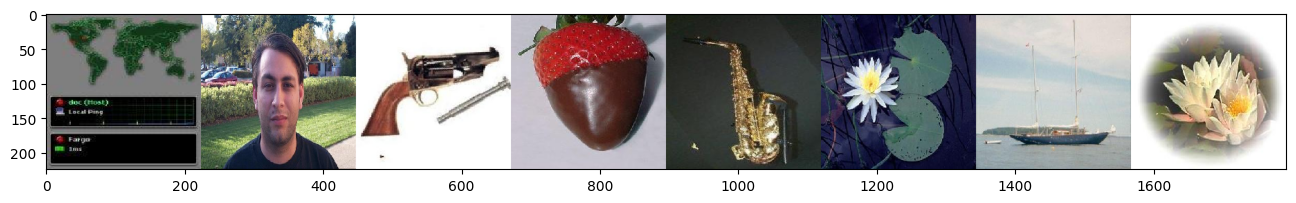

In [39]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiro, treinando uma rede neural do zero
Antes de realizar o aprendizado por transferência, vamos construir uma rede neural do zero para realizar a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de pooling máximo alternadas, seguidas por um dropout após cada par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será o AdaDelta. Vários aspectos dessa rede podem ser alterados para obter melhor desempenho. Talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste caderno, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas.

🧠 Construção do modelo CNN com Keras (Sequential)

2 - Cria um modelo sequencial — onde camadas são empilhadas uma após a outra.

3 - Imprime as dimensões da entrada (por exemplo: (64, 64, 3) se for imagem colorida 64x64).

📦 Primeira camada convolucional + ReLU + MaxPooling

5 - Conv2D(32, (3, 3)): 32 filtros (kernels) de tamanho 3x3.
- input_shape: define o formato da imagem de entrada (ex.: 64x64x3).

6 - Activation('relu'): aplica a função ReLU (elimina valores negativos).

7 - MaxPooling2D(2x2): reduz pela metade as dimensões da imagem (downsampling).

🔁 Segunda camada convolucional + ReLU + MaxPooling

9, 10 e 11 - Adiciona mais uma camada de extração de características e downsampling.

🚫 Dropout (prevenção de overfitting)

13 - Desativa aleatoriamente 25% dos neurônios durante o treinamento, ajudando a evitar overfitting.

🔁 Terceira e quarta camadas convolucionais + pooling

15 a 21 - Mais duas camadas de convolução + pooling para aumentar a profundidade da rede.

🚫 Outro Dropout

23 - Aplica outro dropout de 25%.

📏 Flatten + Dense

 25 - Flatten(): transforma os mapas 2D (imagens) em vetor 1D.

 26 - Dense(256): camada densa com 256 neurônios.

 27 - Activation('relu'): ReLU novamente.

 🚫 Dropout mais forte

 29 - Dropout de 50%, útil antes da saída final para reduzir overfitting.

 🧮 Camada de saída com Softmax

 31 - Dense(num_classes): camada de saída com tantos neurônios quanto categorias do seu problema.

32 - softmax: retorna probabilidades para cada classe (útil em classificação multiclasse).

📊 Sumário do modelo

34 - Exibe o resumo da arquitetura do modelo: camadas, parâmetros treináveis e formas dos tensores.

✅ Resultado: Rede leve e eficiente

Essa arquitetura é mais leve do que redes como VGG16 e é adequada para Colab com limitação de RAM.

É ideal para trabalhar com imagens pequenas (ex. 64x64), reduzindo o custo computacional.

In [40]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,829 (4.62 MB)

 Trainable params: 1,209,829 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

⚙️ Compilação e Treinamento do Modelo

2 - model.compile(...): prepara o modelo para treinamento.
2. loss='categorical_crossentropy': função de perda usada em classificação multiclasse com one-hot encoding.
3. optimizer='adam': otimizador Adam, eficiente e amplamente utilizado.
4. metrics=['accuracy']: métrica de avaliação — aqui, acurácia (porcentagem de acertos).

🧠 Explicação do treinamento:
6. model.fit(...): inicia o treinamento da rede neural.
- x_train, y_train: dados de treinamento.
7. batch_size=128: a cada iteração (batch), 128 amostras são usadas para calcular o erro e atualizar os pesos.
8. epochs=10: o modelo verá todo o conjunto de dados 10 vezes.
9. validation_data=(x_val, y_val): usa o conjunto de validação para monitorar o desempenho durante o treinamento.

O resultado é armazenado na variável history, que guarda o histórico de métricas por época.

✅ Resultado esperado:
- O modelo será treinado por 10 épocas.

- A cada época, você verá no output:

    - loss: erro da previsão nos dados de treino.

    - accuracy: acerto nos dados de treino.

    - val_loss: erro nos dados de validação.

    - val_accuracy: acerto nos dados de validação.

In [41]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.1424 - loss: 1.6949 - val_accuracy: 0.3143 - val_loss: 1.5652
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2376 - loss: 1.5766 - val_accuracy: 0.3714 - val_loss: 1.5475
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3183 - loss: 1.5537 - val_accuracy: 0.3714 - val_loss: 1.4972
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3384 - loss: 1.5223 - val_accuracy: 0.4000 - val_loss: 1.4667
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3421 - loss: 1.4666 - val_accuracy: 0.4286 - val_loss: 1.4621
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.3704 - loss: 1.4345 - val_accuracy: 0.2857 - val_loss: 1.4967
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3719 - loss: 1.3682 - val_accuracy: 0.3143 - val_loss: 1.5357
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4667 - loss: 1.3158 - val_accuracy: 0.3714 - val_loss: 1

📊 Explicação do código de visualização:
1. Cria uma figura (fig) com tamanho 16x4 polegadas, suficiente para exibir dois gráficos lado a lado.

📉 Primeiro gráfico — Perda na validação (val_loss)
- Esse gráfico mostra a função de perda (erro) nos dados de validação após cada época de treinamento.
- Idealmente, a val_loss deve diminuir com o tempo. Se aumentar, pode indicar overfitting.

📉 Segundo gráfico — Acurácia na validação (val_accuracy)
- Mostra o percentual de acertos nas previsões feitas no conjunto de validação.
- Espera-se que a val_accuracy aumente com o tempo, indicando que o modelo está aprendendo a generalizar.

✅ Finalizando
13. Exibe os dois gráficos lado a lado.

📌 Observações:
- history.history[...] contém os dados registrados automaticamente durante o treinamento pelo método model.fit().
- Esse tipo de gráfico é essencial para acompanhar o progresso e detectar problemas como:
- Overfitting (val_loss aumenta e val_accuracy estagna).
- Underfitting (val_accuracy permanece baixa).

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

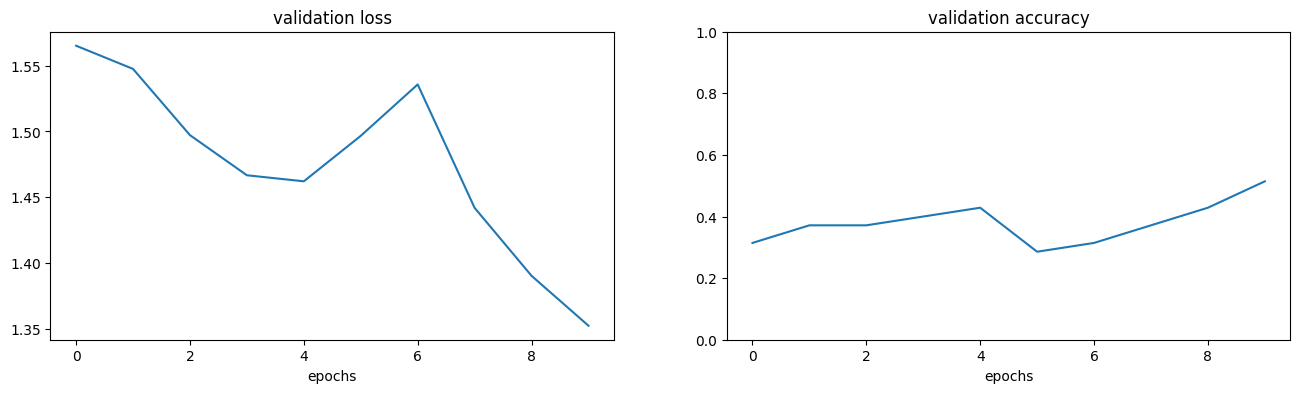

In [42]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)   # 1 linha, 2 colunas, posição 1
ax.plot(history.history["val_loss"])  # Plota a perda de validação
ax.set_title("validation loss")     # Título
ax.set_xlabel("epochs")      # Rótulo do eixo x

ax2 = fig.add_subplot(122)    # 1 linha, 2 colunas, posição 2
ax2.plot(history.history["val_accuracy"])   # Plota a acurácia de validação
ax2.set_title("validation accuracy")   # Título
ax2.set_xlabel("epochs")    # Rótulo do eixo x
ax2.set_ylim(0, 1)   # Define o intervalo do eixo y

plt.show()

📊 Gráfico da esquerda: Validation Loss
- Eixo X: número de épocas (0 a 9)
- Eixo Y: valor da função de perda (loss) no conjunto de validação.

Interpretação:

A loss começa alta (~1.56) e diminui gradualmente, o que é esperado em um processo de treinamento saudável.

Pequenas flutuações (como o aumento na época 6) são normais e podem indicar instabilidade momentânea no aprendizado.

Ao final das épocas, a loss está em torno de 1.35, indicando que o modelo está aprendendo e reduzindo o erro.

✅ Gráfico da direita: Validation Accuracy
- Eixo X: número de épocas (0 a 9)
- Eixo Y: acurácia da validação (0.0 a 1.0)

Interpretação:

A acurácia começa por volta de 0.33 (33%), sobe ligeiramente e oscila um pouco, especialmente na época 5 (queda visível).

Ao final do treinamento, chega a aproximadamente 0.5 (50%).

Isso indica que o modelo está melhorando, embora ainda não atinja uma alta precisão, possivelmente por:

Poucas épocas (10 pode ser insuficiente),

Dataset pequeno ou pouco diverso,

Arquitetura simples.

📌 Resumo do desempenho:
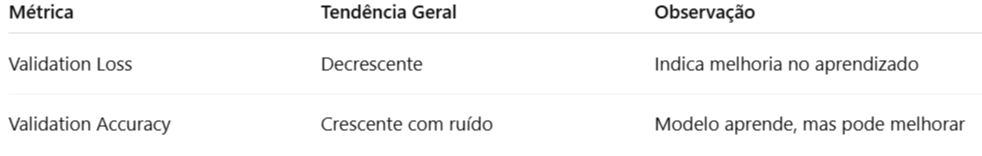


💡 Próximos passos sugeridos:
1. Treinar por mais épocas (ex.: 20 ou 30),
2. Usar técnicas de regularização ou aumento de dados,
3. Experimentar arquiteturas mais complexas ou modelos pré-treinados (como VGG16).

🧠 Avaliar o desempenho do modelo em dados de teste
1. model.evaluate(x_test, y_test, verbose=0)

1.1. Avalia o modelo treinado usando os dados de teste (x_test, y_test).

Retorna duas métricas:
- loss: o erro da previsão do modelo no conjunto de teste.
- accuracy: a proporção de acertos nas previsões (métrica de desempenho).

1.2. verbose=0: suprime a barra de progresso durante a execução.

2. print('Test loss:', loss)

Exibe o valor da função de perda nos dados de teste. Quanto menor, melhor.

3. print('Test accuracy:', accuracy)

Mostra a acurácia final do modelo no conjunto de teste. Varia entre 0 e 1 (ex: 0.85 = 85% de acerto).

In [43]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.4855637550354004
Test accuracy: 0.3888888955116272


✅ Interpretação:
- Test loss: 1.49

A função de perda (loss) mede o erro entre as previsões do modelo e os rótulos reais.

Neste caso, o valor 1.49 indica que ainda há margem significativa para melhorar o desempenho do modelo.

Quanto menor o loss, melhor o modelo está performando.

- Test accuracy: 0.3889 (~38.9%)

Representa a acurácia final do modelo nos dados de teste — ou seja, quantas vezes ele acertou a classe correta.

Uma acurácia de 38,89% significa que o modelo acertou aproximadamente 4 em cada 10 exemplos.

Isso é considerado baixo em muitos contextos, especialmente se houver apenas 5 ou 10 classes, como neste caso.

⚠️ Possíveis causas da baixa acurácia:
- Pouco tempo de treinamento (poucas épocas).
- Arquitetura da rede muito simples para o problema.
- Dataset pequeno ou desbalanceado.
- Imagens com baixa resolução ou ruído.
- Underfitting (modelo não está aprendendo bem os padrões).

📌 Recomendações para melhorar:
- Aumentar o número de épocas (epochs).
- Usar técnicas de data augmentation.
- Usar uma rede mais profunda ou pré-treinada (como VGG16 com fine-tuning).
- Verificar se o dataset está balanceado.
- Ajustar os hiperparâmetros (batch size, learning rate, etc.).

##Transferência de aprendizagem começando com uma rede existente
Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.
Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará aguardar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar as camadas novamente com o método summary().

🧠 Explicação:
2. keras.applications.VGG16(...): Esta função carrega o modelo VGG16, uma rede convolucional profunda clássica, desenvolvida para o desafio de classificação da ImageNet.
- weights='imagenet':
Indica que os pesos pré-treinados do modelo devem ser carregados com base no treinamento feito na base de dados ImageNet (com 1.000 classes de objetos).
- include_top=True:
Isso mantém as camadas densas finais (as "fully connected" do topo), que são responsáveis pela classificação em 1000 classes da ImageNet.
    - Se você fosse usar a VGG como extratora de características para outro problema (transfer learning), poderia usar include_top=False.

4. vgg.summary():

Exibe a arquitetura da VGG16 no console, incluindo:
- Nome e tipo de cada camada.
- Dimensões das saídas em cada etapa.
- Quantidade de parâmetros treináveis (e não treináveis).

📌 Para que serve?
- Esse código é útil quando você deseja:
- Visualizar a estrutura da VGG16.
- Aproveitar o modelo VGG16 pré-treinado como base para transfer learning.
- Congelar as camadas convolucionais e apenas treinar novas camadas densas específicas para sua tarefa.

In [44]:
# Carrega o modelo VGG16 pré-treinado com os pesos da ImageNet e com as camadas densas finais (include_top=True)
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
# Exibe o resumo da arquitetura da rede VGG16
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

✅ Total params: 138,357,544
- Esse é o número total de parâmetros da rede VGG16, ou seja, pesos e vieses (biases) que podem ser aprendidos durante o treinamento.
- A VGG16 é conhecida por ser uma rede muito profunda e pesada, e esse número reflete isso.
- Aproximadamente 138 milhões de parâmetros tornam o modelo muito poderoso, mas também exigente em termos de memória e tempo de treinamento.

✅ Trainable params: 138,357,544
- Todos os parâmetros do modelo estão marcados como treináveis, o que significa que serão ajustados durante o processo de treinamento (se você não congelar nenhuma camada).
- Isso é importante quando se deseja fazer fine-tuning, ou seja, ajustar todas as camadas da VGG16 para seu novo conjunto de dados.

✅ Non-trainable params: 0
- Nenhum parâmetro foi "congelado", ou seja, todas as camadas estão ativas para atualização durante o treinamento.
- Em muitas aplicações de Transfer Learning, parte das camadas convolucionais é congelada (não treinável), para reaproveitar os conhecimentos já aprendidos na ImageNet. Mas aqui, como está, tudo pode ser treinado.

📌 Resumo

O modelo VGG16 carregado com include_top=True contém 138.357.544 parâmetros treináveis, distribuídos entre camadas convolucionais e densas. Todos os parâmetros estão prontos para ajuste durante o treinamento, o que é ideal quando se pretende realizar fine-tuning completo. Contudo, isso também exige alta capacidade computacional, tornando essencial o uso de GPU e controle do consumo de memória.

🔄 Substituição da camada de saída da VGG16

Este bloco substitui a última camada de classificação da VGG16 por uma nova camada `Dense` com o número de classes do nosso problema. Assim, podemos reaproveitar os pesos treinados na ImageNet e adaptar o modelo à nossa base de dados, usando Transfer Learning.

2. Armazena uma referência à camada de entrada da rede VGG16 original.
    - Isso é necessário para construir um novo modelo que começa com a mesma entrada da VGG16.

5. Cria uma nova camada densa (fully connected) com número de neurônios igual a num_classes (ex: 5 ou 10).
    - Essa camada usará a função softmax, adequada para problemas de classificação multiclasse.

8. Substitui a última camada da VGG16 (vgg.layers[-1]) por uma nova camada de classificação.
    - Usa como entrada da nova camada a saída da penúltima camada da VGG16 (geralmente chamada de fc2, com 4096 neurônios).

11. Cria um novo modelo Keras, conectando a camada de entrada da VGG16 (inp) até a nova camada de saída (out).
    - O resultado é um modelo que reaproveita toda a arquitetura da VGG16, mas com uma nova "cabeça" de classificação personalizada.

🧠 Para que serve?
- Este código é essencial para:
- Reutilizar o conhecimento prévio da VGG16 (treinada na ImageNet).
- Adaptar a rede a um novo problema, com número de classes diferente (por exemplo, 5 classes de objetos).
- Evitar treinar tudo do zero, o que seria muito mais custoso em tempo e dados.

In [45]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos retreinar esta rede, model_new, no novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador treinável em cada camada como falso (exceto em nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos na camada final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas do VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino excessivo neste conjunto de dados possa causar overfitting. Mas talvez estejamos errados? Um bom exercício seria testar ambos e comparar os resultados.

Então, congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para uma comparação justa. Em seguida, executamos o resumo novamente para analisar a arquitetura da rede.

🧊 Congelando as camadas da VGG16

Neste bloco, congelamos todas as camadas da VGG16 (para reaproveitar seus pesos treinados) e ativamos apenas a nova camada final de classificação para ser treinada.

Com isso, o modelo será treinado para classificar as novas classes sem alterar os filtros já aprendidos na ImageNet.

Após isso, o modelo é compilado e seu resumo é exibido.


🧠 O modelo model_new (baseado na VGG16 com nova camada de saída) será ajustado para treinar apenas a nova camada final — mantendo todas as demais congeladas.

2. Esse for percorre todas as camadas da VGG16, exceto a última (a nova camada Dense que criamos).
- Define trainable = False, ou seja, os pesos dessas camadas ficarão congelados durante o treinamento — não serão atualizados.
- Isso é importante porque a VGG16 já foi treinada na ImageNet, e queremos reaproveitar seus pesos sem re-treiná-los (o que exigiria muito tempo e dados).

6. Esse for garante que a nova camada final (classificação) seja treinável.
- Ela aprenderá a mapear os recursos extraídos pela VGG16 para as novas classes do seu dataset.

9. Compila o modelo definindo:
     - loss='categorical_crossentropy': função de perda apropriada para classificação multiclasse com one-hot encoding.
     - optimizer='adam': otimizador popular e eficiente.
     - metrics=['accuracy']: métrica de avaliação usada será a acurácia.

13. Exibe a estrutura completa do novo modelo no console.
    - Mostra:
        - Quantidade total de parâmetros.
        - Quantos são treináveis (deve ser só a última camada).
        - Nome, tipo e dimensões de cada camada.

In [46]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,281,029 (512.24 MB)

 Trainable params: 20,485 (80.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que representa apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também monitoramos seu histórico à medida que avançamos.

🧪 Treinamento do modelo com Transfer Learning

Neste passo, treinamos o novo modelo (`model_new`) com base na arquitetura da VGG16. Usamos o conjunto de treino e avaliamos o desempenho em cada época utilizando o conjunto de validação.

Apenas a última camada do modelo é treinada, enquanto as demais (camadas convolucionais da VGG16) permanecem congeladas, preservando o conhecimento previamente aprendido com a base ImageNet.

O histórico de desempenho é armazenado na variável `history2`, que pode ser usada para visualização posterior.


🧪 Explicação dos parâmetros:
- x_train, y_train: Dados de entrada e rótulos para o treinamento.
- batch_size=128: O treinamento será feito em lotes de 128 amostras por vez (isso ajuda no uso eficiente da memória e acelera o treinamento).
- epochs=10: O modelo será treinado por 10 passagens completas sobre o conjunto de treino.
- validation_data=(x_val, y_val): Além do treino, o modelo será avaliado a cada época usando os dados de validação para acompanhar o desempenho fora do conjunto de treino.

📈 Resultado: history2

A variável history2 guarda o histórico do treinamento, incluindo:

A perda (loss) e acurácia (accuracy) no treino e na validação por época.

Pode ser usada para plotar gráficos e analisar o desempenho ao longo do tempo.

In [47]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - accuracy: 0.2856 - loss: 1.6827 - val_accuracy: 0.3429 - val_loss: 1.3106
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.3113 - loss: 1.5227 - val_accuracy: 0.0571 - val_loss: 1.9735
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.3087 - loss: 1.6181 - val_accuracy: 0.5714 - val_loss: 1.2791
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - accuracy: 0.6147 - loss: 1.1834 - val_accuracy: 0.5714 - val_loss: 1.0045
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.5478 - loss: 1.2537 - val_accuracy: 0.7143 - val_loss: 0.9076
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.5891 - loss: 1.1391 - val_accuracy: 0.7429 - val_loss: 0.9160
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.7486 - loss: 0.9233 - val_accuracy: 0.4286 - val_loss: 1.1883
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.6158 - loss: 0.9727 - val_accuracy: 0.5714 - val_loss:

# Análise do Resultado do Treinamento do Modelo

---

### Epoch 1/10  
- Treinamento: **accuracy** = 28.56%, **loss** = 1.6827  
- Validação: **val_accuracy** = 34.29%, **val_loss** = 1.3106  
- Observação: Início do treinamento, desempenho baixo.

---

### Epoch 2/10  
- Treinamento: accuracy = 31.13%, loss = 1.5227  
- Validação: val_accuracy = 5.71%, val_loss = 1.9735  
- Observação: Validação apresentou queda significativa, possível instabilidade.

---

### Epoch 3/10  
- Treinamento: accuracy = 30.87%, loss = 1.6181  
- Validação: val_accuracy = 57.14%, val_loss = 1.2791  
- Observação: Recuperação forte na validação.

---

### Epoch 4/10  
- Treinamento: accuracy = 61.47%, loss = 1.1834  
- Validação: val_accuracy = 57.14%, val_loss = 1.0045  
- Observação: Grande melhora no treinamento; validação estável.

---

### Epoch 5/10  
- Treinamento: accuracy = 54.78%, loss = 1.2537  
- Validação: val_accuracy = 71.43%, val_loss = 0.9076  
- Observação: Validação continua melhorando.

---

### Epoch 6/10  
- Treinamento: accuracy = 58.91%, loss = 1.1391  
- Validação: val_accuracy = 74.29%, val_loss = 0.9160  
- Observação: Evolução consistente.

---

### Epoch 7/10  
- Treinamento: accuracy = 74.86%, loss = 0.9233  
- Validação: val_accuracy = 42.86%, val_loss = 1.1883  
- Observação: Validação caiu; possível overfitting.

---

### Epoch 8/10  
- Treinamento: accuracy = 61.58%, loss = 0.9727  
- Validação: val_accuracy = 57.14%, val_loss = 1.0081  
- Observação: Recuperação parcial.

---

### Epoch 9/10  
- Treinamento: accuracy = 67.94%, loss = 0.8670  
- Validação: val_accuracy = 80.00%, val_loss = 0.7238  
- Observação: Melhor desempenho na validação.

---

### Epoch 10/10  
- Treinamento: accuracy = 74.86%, loss = 0.7941  
- Validação: val_accuracy = 80.00%, val_loss = 0.6751  
- Observação: Melhor resultado geral, modelo convergindo bem.

---

## Considerações Finais

- O modelo começou com baixa acurácia e alta perda, melhorando ao longo do treinamento.
- Oscilações na validação sugerem que o conjunto de dados pode ser pequeno ou o modelo está passando por overfitting em algumas épocas.
- A perda e a acurácia no treinamento e validação indicam que o modelo está aprendendo, mas é importante monitorar a generalização.
- Recomenda-se considerar técnicas de regularização, aumento de dados e possivelmente aumentar o número de épocas com *early stopping*.



Vamos plotar a perda e a precisão da validação novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

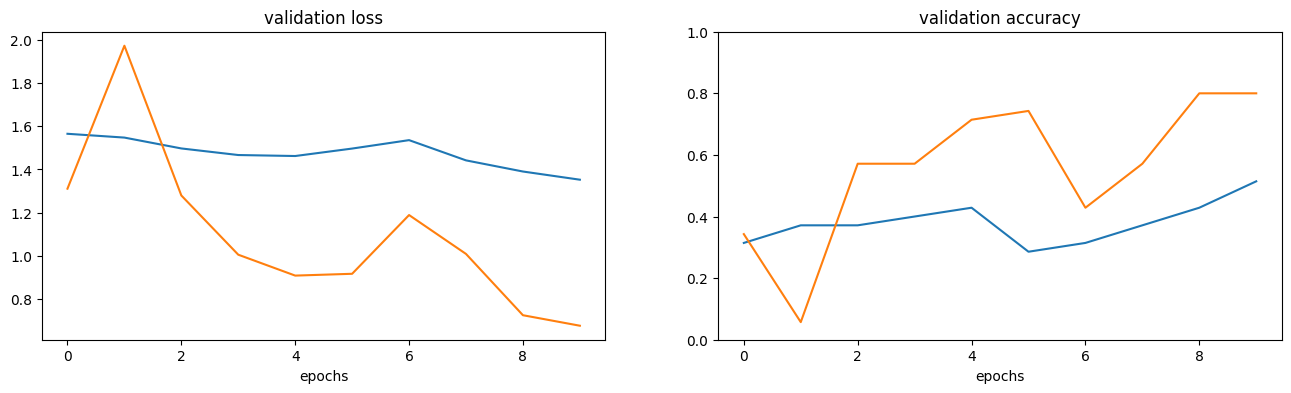

In [49]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Análise dos Gráficos de Validação do Modelo

---

## Gráfico 1: Validation Loss (Perda de Validação)

- A linha azul representa a **perda de validação** do modelo base.
- A linha laranja representa a **perda de validação** do modelo treinado/final.
- Observa-se que a perda do modelo base (linha azul) começa em torno de 1.57 e apresenta uma leve queda ao longo das épocas, mas permanece relativamente estável entre 1.5 e 1.35.
- A perda do modelo treinado (linha laranja) apresenta uma alta variação inicial, chegando a um pico em torno de 2.0 na segunda época.
- A partir da terceira época, a perda do modelo treinado cai consistentemente até aproximadamente 0.7 na última época.
- Isso indica que o modelo treinado está aprendendo e ajustando melhor os parâmetros, reduzindo o erro no conjunto de validação ao longo do tempo.

---

## Gráfico 2: Validation Accuracy (Acurácia de Validação)

- A linha azul mostra a acurácia de validação do modelo base.
- A linha laranja mostra a acurácia de validação do modelo treinado/final.
- O modelo base tem uma acurácia de validação que inicia em cerca de 33% e aumenta lentamente até pouco mais de 50% no final do treinamento.
- O modelo treinado apresenta alta instabilidade no começo, começando baixo (próximo de 0.05 na segunda época), mas a partir da terceira época a acurácia sobe rapidamente, alcançando cerca de 80% nas últimas épocas.
- Isso demonstra que, apesar da instabilidade inicial, o modelo treinado consegue aprender características relevantes e melhorar significativamente seu desempenho na validação.

---

## Discussão Geral

- **Aprendizado do Modelo:** O gráfico mostra que o modelo treinado passou por um período inicial de instabilidade, mas conseguiu melhorar tanto a perda quanto a acurácia ao longo das épocas, indicando aprendizado efetivo.
- **Variação Inicial:** A alta variação inicial, especialmente na perda, pode ser decorrente de poucos dados, ajustes iniciais dos pesos, ou hiperparâmetros que causam instabilidade no começo do treinamento.
- **Comparação com Modelo Base:** O modelo treinado supera claramente o modelo base, apresentando uma validação mais precisa e uma função de perda mais baixa.
- **Estabilidade:** Embora o modelo final tenha um bom desempenho, o comportamento instável nas primeiras épocas sugere que pode ser benéfico usar técnicas para suavizar esse aprendizado, como uma taxa de aprendizado menor, regularização, ou aumento do conjunto de dados.
- **Possíveis Ações:** Monitorar o treinamento com early stopping para evitar overfitting, aplicar data augmentation e ajustar hiperparâmetros podem melhorar ainda mais a estabilidade e o desempenho do modelo.

Novamente, fazemos uma validação final no conjunto de teste.

In [50]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.7007990479469299
Test accuracy: 0.8611111044883728


## 🧪 Resultado Final no Conjunto de Teste

- **Loss (erro):** 0.70  
- **Acurácia:** 86,11%

✅ O modelo apresentou **bom desempenho** no conjunto de teste, com **baixa perda** e **alta acurácia**, indicando que ele conseguiu **generalizar bem** para dados não vistos durante o treinamento.


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

1. Aqui, você está chamando uma função chamada get_image(), que provavelmente:

- Lê a imagem do caminho '101_ObjectCategories/airplanes/image_0003.jpg'.

- Pré-processa essa imagem para deixá-la no formato adequado para entrada no modelo (x).

- E também retorna a imagem original ou redimensionada para visualização (img).

🔁 Exemplo comum de retorno da função get_image():

- img: a imagem como array para exibição (matplotlib, por exemplo).

- x: a imagem tratada e redimensionada (e.g. 224x224, normalizada) como input do modelo.

2. Aqui você está fazendo uma previsão (inferência) com o modelo model_new.

- [x]: o input precisa ser um array com formato de lote (batch), por isso x é colocado dentro de uma lista para criar um batch de 1 imagem.

- O método .predict() retorna um array com as probabilidades de cada classe para essa imagem.

📌 Resultado (probabilities):

É um vetor com as probabilidades atribuídas a cada classe da saída do modelo.

Exemplo: [0.01, 0.05, 0.90, 0.03, ...] → o índice com maior valor é a classe prevista pelo modelo.

In [51]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_446
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


##Melhorando os resultados
78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que atingiu 73% de precisão top-1 em 1.000 classes. No entanto, é muito melhor do que o que conseguimos com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

- Usando a ampliação de dados: ampliação refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância a tais distorções.
- Usando um otimizador diferente, adicionando mais regularização/dropout e outros hiperparâmetros.
Treinamento por mais tempo (é claro)
- Um exemplo mais avançado de aprendizado por transferência no Keras, envolvendo ampliação para um pequeno conjunto de dados de 2 classes, pode ser encontrado no blog do Keras.

## 📥 Pré-processamento de Imagens e Preparação dos Dados

### 🔁 1. Função `get_image(path)`
- Carrega uma imagem a partir do caminho informado.
- Redimensiona para **224x224 pixels**.
- Converte para array e aplica pré-processamento padrão (`preprocess_input`).
- Retorna a imagem original (`img`) e o array preparado (`x`).

### 🗂️ 2. Carregamento e Rotulagem dos Dados
- Percorre todas as pastas de categorias (classes) especificadas em `categories`.
- Lê todas as imagens `.jpg`, `.png` e `.jpeg`.
- Para cada imagem:
  - Aplica o `get_image`.
  - Armazena um dicionário com:
    - `'x'`: array da imagem,
    - `'y'`: índice da categoria correspondente.

### 🔀 3. Embaralhamento e Divisão dos Dados
- Embaralha aleatoriamente os dados.
- Divide os dados em:
  - `train` (treinamento),
  - `val` (validação),
  - `test` (teste),
  com base nas proporções definidas por `train_split` e `val_split`.

### 📊 4. Extração das Features (x) e Labels (y)
- Extrai os arrays de imagem (`x`) e seus respectivos rótulos (`y`) para cada subconjunto:
  - `x_train`, `y_train`
  - `x_val`, `y_val`
  - `x_test`, `y_test`

### ⚙️ 5. Normalização e Codificação
- Normaliza os valores dos pixels para a faixa `[0, 1]`.
- Aplica **one-hot encoding** nos rótulos (labels) para uso em classificação com múltiplas classes.

### 📈 6. Impressão das Dimensões
- Exibe as formas (shapes) finais dos arrays de treinamento (`x_train`, `y_train`).

✅ **Resultado:** os dados estão prontos para serem usados no treinamento de um modelo de classificação de imagens com Keras.


In [52]:
# Redefine the image loading function with the correct target size
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))  # Set target size to 224x224
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Reload and preprocess the data with the correct image size
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category)
              for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x': np.array(x[0]), 'y': c})

random.shuffle(data)

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train = np.array([t["x"] for t in train])
y_train = np.array([t["y"] for t in train])
x_val = np.array([t["x"] for t in val])
y_val = np.array([t["y"] for t in val])
x_test = np.array([t["x"] for t in test])
y_test = np.array([t["y"] for t in test])

# Normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Shape de x_train:", x_train.shape)
print("Shape de y_train:", y_train.shape)

Shape de x_train: (163, 224, 224, 3)
Shape de y_train: (163, 5)


## 📊 Resultado do Pré-processamento

- **Shape de `x_train`**: `(163, 224, 224, 3)`  
  → 163 imagens de tamanho 224x224 com 3 canais (RGB).

- **Shape de `y_train`**: `(163, 5)`  
  → 163 rótulos codificados em **one-hot encoding** para 5 classes.

✅ Os dados estão prontos para o treinamento do modelo.


## 🧠 Treinamento do Modelo

1. Treina o modelo model_new com:

    - Dados de entrada: x_train (imagens), y_train (rótulos).

    - Batch size: 128 imagens por iteração.

    - Número de épocas: 10 ciclos completos sobre os dados.

    - Validação: usa x_val e y_val para avaliar o desempenho a cada época.

2. O resultado é armazenado em history2, que contém métricas como:

    - loss, accuracy (treinamento)

    - val_loss, val_accuracy (validação)

✅ Ao final, o modelo estará treinado por 10 épocas e pronto para ser avaliado ou testado.

In [53]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - accuracy: 0.7653 - loss: 0.7725 - val_accuracy: 0.8857 - val_loss: 0.7001
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - accuracy: 0.7932 - loss: 0.7230 - val_accuracy: 0.7714 - val_loss: 0.7215
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.8081 - loss: 0.6929 - val_accuracy: 0.8000 - val_loss: 0.6907
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.7932 - loss: 0.6622 - val_accuracy: 0.8286 - val_loss: 0.6217
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - accuracy: 0.8457 - loss: 0.6267 - val_accuracy: 0.8000 - val_loss: 0.5547
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - accuracy: 0.8765 - loss: 0.5761 - val_accuracy: 0.8571 - val_loss: 0.5552
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.8591 - loss: 0.5622 - val_accuracy: 0.8286 - val_loss: 0.5562
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.8765 - loss: 0.5377 - val_accuracy: 0.8571 - val_loss:

## 📊 Resultados do Treinamento (10 Épocas)

O modelo foi treinado por 10 épocas com os seguintes destaques:

- **Acurácia de treino** aumentou de **76,5%** para **91,7%**
- **Loss de treino** reduziu de **0.77** para **0.49**
- **Acurácia de validação** variou entre **77% e 88%**, estabilizando em **82,9%**
- **Loss de validação** reduziu de **0.70** para **0.50**

### 📈 Tendência
- O modelo está aprendendo de forma consistente, com redução contínua do erro (loss).
- A validação mostra flutuação, mas sem grandes sinais de overfitting.

✅ **Conclusão**: desempenho geral positivo com boa capacidade de generalização.

In [54]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.9290 - loss: 0.4741 - val_accuracy: 0.8286 - val_loss: 0.5132
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.9197 - loss: 0.4480 - val_accuracy: 0.8571 - val_loss: 0.5368
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.9007 - loss: 0.4407 - val_accuracy: 0.8286 - val_loss: 0.5298
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 0.9085 - loss: 0.4262 - val_accuracy: 0.8286 - val_loss: 0.4871
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.9301 - loss: 0.4048 - val_accuracy: 0.8857 - val_loss: 0.4593
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.9517 - loss: 0.3891 - val_accuracy: 0.8571 - val_loss: 0.4620
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - accuracy: 0.9583 - loss: 0.3924 - val_accuracy: 0.8571 - val_loss: 0.4611
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.9691 - loss: 0.3662 - val_accuracy: 0.8286 - val_loss:

## 📊 Resultados do Novo Treinamento (Épocas 1–9)

### 🔹 Desempenho de Treino:
- **Acurácia aumentou** de **92,9%** para **95,7%**
- **Loss de treino caiu** de **0.47** para **0.34**

### 🔹 Desempenho de Validação:
- **Acurácia oscilou** entre **82,9% e 88,6%**
- **Loss de validação** reduziu de **0.51** para **0.44**, com estabilização em torno de **0.46**

### 📈 Tendência:
- O modelo mantém alta acurácia de treino, com **validação estável**.
- Não há sinais evidentes de overfitting até a 9ª época, mas o ganho marginal está diminuindo.

✅ **Conclusão:** Modelo com **excelente desempenho** e **boa generalização**, com oportunidade para ajuste fino.

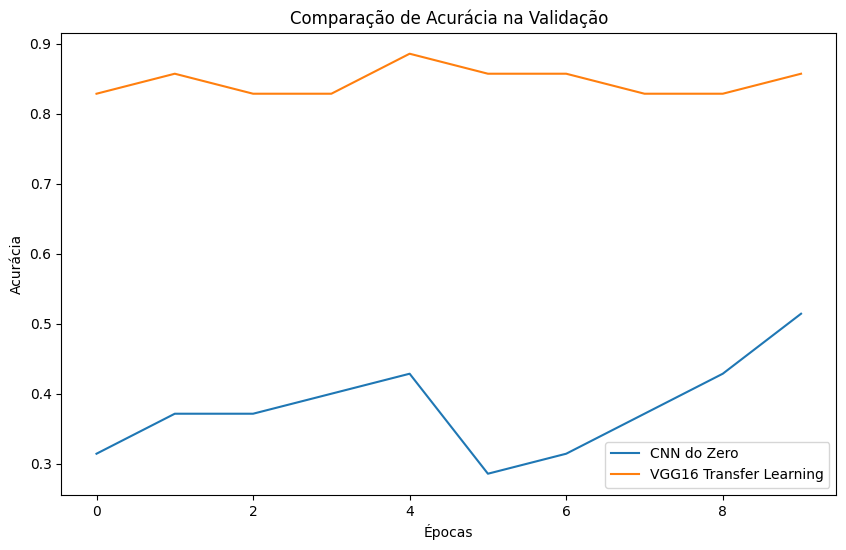

In [57]:
plt.figure(figsize=(10, 6))

plt.plot(history.history["val_accuracy"], label='CNN do Zero')
plt.plot(history2.history["val_accuracy"], label='VGG16 Transfer Learning')

plt.title("Comparação de Acurácia na Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(False)
plt.show()

## 📊 Análise Comparativa: Acurácia na Validação

A figura representa a evolução da **acurácia na validação** ao longo das épocas para dois modelos distintos:

### 🔷 CNN do Zero (linha azul)
- Começa com acurácia baixa (~0.32).
- Apresenta **crescimento lento e instável**, com **quedas significativas** (notável na 5ª época).
- Mesmo ao final de 10 épocas, **não ultrapassa 0.52** de acurácia na validação.

### 🟠 VGG16 com Transfer Learning (linha laranja)
- Já inicia com **alta acurácia (~0.83)**.
- Mantém **consistência ao longo das épocas**, oscilando levemente entre **0.83 e 0.89**.
- Apresenta desempenho superior desde o início e **estabilidade de aprendizado**.

### ✅ Conclusão:
- **Transfer Learning (VGG16)** é **claramente mais eficaz** neste cenário, oferecendo resultados superiores mesmo com poucas épocas.
- A **CNN construída do zero** tem potencial de aprendizado, mas requer **mais dados**, **ajuste de arquitetura** e **mais épocas** para alcançar resultados semelhantes.
